# 02477 Bayesian Machine Learning - Exercise 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as snb
import os

from scipy.stats import binom as binom_dist

snb.set_style('darkgrid')
snb.set(font_scale=1.)
colors = 'brgmc'


# Introduction

The purpose of this exercise is to dive deeper into the basic concepts of probabilistic and Bayesian modelling using **logistic regression** as a case-study. Specifically, we will study:

- the probability distributions involved in logistic regression
- how to approximate the posterior distribution of non-conjugate models using simple grid approximations
- how to make predictions using posterior predictive distributions

We will study these concepts using data from Challenger Space Shuttle disaster.


**Content**

- Part 1: Setting up the logistic regression model
- Part 2: The prior, likelihood and posterior
- Part 3: Making predictions using point estimates
- Part 4: Approximating the posterior using a grid approximation
- Part 5: Propagating uncertainty from parameters to predictions



# Dataset: The Challenger Space Shuttle disaster 

On a cold morning on January 28, 1986 the space shuttle called **Challenger** tragically exploded 73 seconds after its launch, killing all 7 crew members. The explosion was later determined to be caused the failure of two out of six so-called o-ring seals in one of the rocket boosters.
The temperature on the day of the launch was close $0^{\circ} C$, which was record-low. The cold weather made the o-rings stiffen, reducing their ability to seal the critical joints, and hence, causing the tragic accident. O-ring failure had previously been observed on 6 of out the 23 prior launches as plotted below.

In this exercise, you will construct a simple Bayesian logistic regression model for predicting the probability of o-ring failure as a function of temperature.

The dataset $\mathcal{D} = \left\lbrace (y_i, t_i) \right\rbrace_{i=1}^{M}$ consists of $M=23$ observations, where $y_i \in \left[0, 1, \dots 6\right]$ denotes the number of failed o-rings for the $i$'th temperature $t_i$. The number of o-rings for all launches were $N = 6$, and hence, the fraction of failed o-rings for the $i$'th launch is $\frac{y_i}{N} = \frac{y_i}{6}$.

See [Wikipedia](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) for more background information.




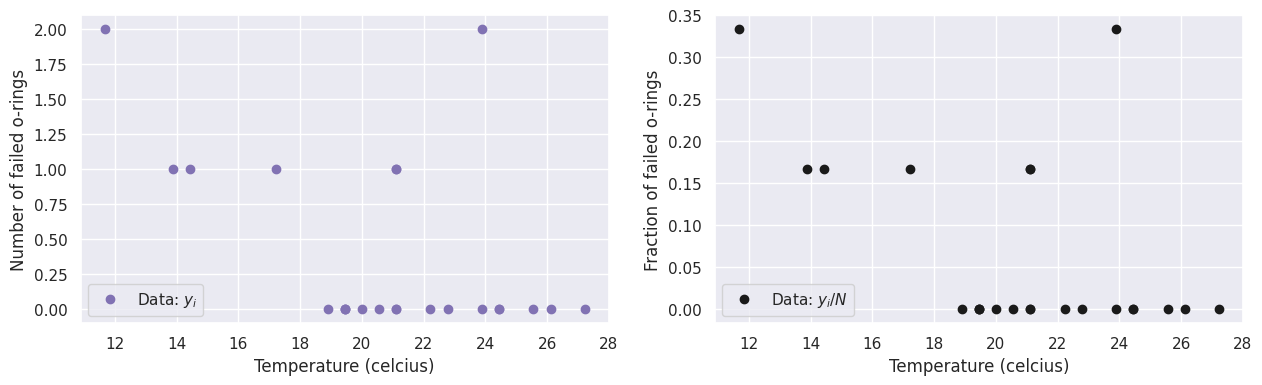

In [2]:
# load data
data = np.load('./orings_data.npz')
t = data['temperature']   # recorded temperature
y = data['failed']        # number of failed o-rings
N = data['count']         # total number of o-rings

# helper function for plotting data
def plot_data(ax=None, counts=True):
    if counts:
        ax.plot(t, y, 'mo', label='Data: $y_i$')
        ax.set(ylabel='Number of failed o-rings')
    else:
        ax.plot(t, y/N, 'ko', label='Data: $y_i/N$')
        ax.set(ylabel='Fraction of failed o-rings')
    ax.set(xlabel='Temperature (celcius)')
    ax.legend(loc='lower left')

# plot
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
plot_data(ax[0])
plot_data(ax[1], counts=False)

Rather than working directly with the temperatures $t_i \in \mathbb{R}$, we will standardize the temperatures to get

$$\begin{align*}
x_i = \frac{t_i - t_{\text{mean}}}{t_{\text{std}}},
\end{align*}$$
where $t_{\text{mean}}$ and $t_{\text{std}}$ are the empirical mean and standard deviation, respectively, of the observed temperatures $\left\lbrace t_i \right\rbrace_{i=1}^M$.

In [3]:
# compute mean and standard deviation of temperatures
tmean, tstd = np.mean(t), np.std(t)

# standardize temperatures
standardize = lambda t_: (t_ - tmean)/tstd
x = standardize(t)

# Part 1:  Setting up the logistic regression model

The total number of o-rings at risk for each launch is $N = 6$ and assuming each of the 6 o-rings can be modelled as conditionally independent Bernoullli trials, the number of failing o-rings for a given temperature can be described by a Binomial-distribution with $N=6$ and some probability $\theta_i$: 

$$\begin{align}
y_i \sim \text{Bin}(N, \theta_i),
\end{align}
$$

where $\theta_i \in \left[0, 1\right]$ depends on the temperature.

Rather than imposing Beta-distributions as prior distributions for each $\theta_i$, we assume $\theta_i$ can be modelled as is a function of the temperature. Specifically, we assume

$\begin{align}
\theta(x) = \sigma(\alpha + \beta x),
\end{align}
$

where $\alpha, \beta \in \mathbb{R}$ are parameters to be estimated and $\sigma: \mathbb{R} \rightarrow \left[0, 1\right]$ is the **logistic sigmoid function**, i.e. $\sigma(x) = (1+\exp(-x))^{-1}$. For later references, we will denote the linear component of the model as $f(x)$, i.e.

$\begin{align}
f(x) = \alpha + \beta x.
\end{align}
$
Note that both $\theta(x)$ and $f(x)$ do indeed depend on $\alpha$ and $\beta$, but we suppress this dependency to ease the notation. The likelihood of the $i$'th data point thus becomes
$
\begin{align}
p(y_i|x_i, \alpha, \beta) = \text{Bin}(y_i|N_i, \theta_i),
\end{align}
$
where we have defined $\theta_i \equiv \theta(x_i) = \sigma(\alpha+\beta x_i)$. Assuming that all observations $\left\lbrace y_i \right\rbrace_{i=1}^M$ are **conditionally independent** given $\theta(x_i)$, the likelihood of the full dataset becomes

$\begin{align}
p(\mathbf{y}|\mathbf{x}, \alpha, \beta) = \prod_{i=1}^M p(y_i|x_i, \alpha, \beta) = \prod_{i=1}^M  \text{Bin}(y_i|N_i, \theta_i),
\end{align}
$

where $\mathbf{y} = [y_1, y_2, \dots, y_M]$ and $\mathbf{x} = [x_1, x_2, \dots, x_M]$. Our goal is to be able to predict $y^*$ for a new temperature $x^*$.  To do this we write down the *predictive likelihood* for $y^*$, i.e.

$\begin{align}
p(y^*|x^*, \alpha, \beta) = \text{Bin}(y^*|N, \theta^*),
\end{align}
$ 

where $\theta^* \equiv \theta(x^*) = \sigma(\alpha + \beta x^*)$. Due to the assumption of conditional independence, we have

$\begin{align}
p(\mathbf{y}, y^*|\mathbf{x}, x^*, \alpha, \beta) = p(\mathbf{y}|\mathbf{x}, \alpha, \beta)p(y^*|x^*, \alpha, \beta) = \underbrace{\prod_{i=1}^M  \text{Bin}(y_i|N_i, \theta_i)}_{p(\mathbf{y}|\mathbf{x}, \alpha, \beta)} \underbrace{\text{Bin}(y^*|N^*, \theta^*)}_{p(y^*|x^*, \alpha, \beta)}.
\end{align}
$

To complete the Bayesian model, we need to impose a distribution on the parameters $\alpha, \beta$. Since we do not have any information about the parameters, we will impose generic Gaussian priors with zero mean:

$\begin{align}
p(\alpha, \beta) = \mathcal{N}(\alpha|0, \sigma^2_\alpha)\mathcal{N}(\beta|0, \sigma^2_{\beta})
\end{align}
$
for $\sigma^2_\alpha, \sigma^2_\beta > 0$. This leads to the following joint distribution for $y^*, \mathbf{y}, \alpha,$ and $\beta$:

$\begin{align}
p(\mathbf{y}, y^*, \alpha, \beta|\mathbf{x}, x^*) = p(y^*|x^*, \alpha, \beta)p(\mathbf{y}|\mathbf{x}, \alpha, \beta) p(\alpha, \beta) = \underbrace{\text{Bin}(y^*|N^*, \theta^*)}_{p(y^*|x^*, \alpha, \beta)}\underbrace{\prod_{i=1}^M  \text{Bin}(y_i|N_i, \theta_i)}_{p(\mathbf{y}|\mathbf{x}, \alpha, \beta)} \underbrace{\mathcal{N}(\alpha|0, \sigma^2_\alpha)\mathcal{N}(\beta|0, \sigma^2_{\beta})}_{p(\alpha, \beta)}.
\end{align}
$

The joint distribution determined how all of the variables of the (e.g. both data and parametes) interact. Because we observe $\mathbf{y}$, we naturally consider the conditional distribution

$\begin{align}
p(y^*, \alpha, \beta|\mathbf{y}, \mathbf{x}, x^*) = \frac{p(\mathbf{y}, y^*, \alpha, \beta|\mathbf{x}, x^*)}{p(\mathbf{y}|\mathbf{x})}
\end{align}$

Our primary goal is to compute the **posterior predictive distribution** $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$, i.e. the **marginal distribution** of $y^*$ conditioned on the observed data, i.e. $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$ which can be obtained by marginalizing over $\alpha$ and $\beta$ via the sum rule:

$\begin{align}
p(y^*|\mathbf{y}, \mathbf{x}, x^*) = \int\int p(y^*, \alpha, \beta|\mathbf{y}, \mathbf{x}, x^*) \text{d} \alpha \text{d}\beta= \int\int \underbrace{p(y^*|x^*, \alpha, \beta)}_{\text{likelihood for }y^*} \underbrace{p(\alpha, \beta|\bm{y}, \bm{x})}_{\text{posterior distribution}} \text{d} \alpha \text{d}\beta.
\end{align}
$

As shown in the last equation, we can obtain the posterior predictive distribution by averaging the predictive likelihood wrt. to the posterior distribution. Hence, our first effort will be to get a handle on the posterior distribution of $\alpha$ and $\beta$ conditioned on $\mathbf{y}$.


**Task 1.1**: Use the **product rule** to write down the joint distribution for $\mathbf{y}, \alpha, $ and $\beta$

*Hint*: This is meant to be an easy task.



**Task 1.2**: Show that $p(\mathbf{y}, \alpha, \beta|\mathbf{x}) = \sum_{y^*}  p(\mathbf{y}, y^*, \alpha, \beta|\mathbf{x}, x^*)$, where the sum is over all possible outcomes of $y^*$.



**Task 1.3**: Use Bayes' rule to express the posterior $p(\alpha, \beta|\mathbf{y}, \mathbf{x})$ in terms of the prior, likelihood and evidence and argue that the posterior is proportional to the joint distribution $p(\mathbf{y}, \alpha, \beta|\mathbf{x})$.



# Part 2:  The prior, likelihood and posterior

The goal of this part is to implement code for evaluating the prior, likelihood and posterior distribution. Due to a combination of **numerical precision** and **mathematical convenience**, we will implement functions for evaluating the logarithm of these distributions. 
Below you are given an incomplete implementation of the logistic regression model. Your task is to complete the implementation. The code contains a few sanity checks that will help to detect potential bugs and errors in your code.


**Task 2.1**: Complete the implementation of the functions *f, theta, log_prior* and *log_likelihood* below.

*Hints*:
- *For implementing the log prior, the function log_npdf is handy.*
- *When implementing the log likelihood, you can  either use *scipy.stats.binom* (imported as binom_dist) or you can implement the PMF of the binomial distribution from scratch.*
- *Note that for each function the output must have the same shape as the inputs. That is, if you run log_prior(1, 1), it should return a scalar. If you run log_prior(alpha_vec, beta_vec), where alpha_vec and beta_vec are [10 x 1] arrays, then the results should also be a [10 x 1] array*


In [4]:
sigmoid = lambda x: 1./(1 + np.exp(-x))
log_npdf = lambda x, m, v: -(x-m)**2/(2*v) - 0.5*np.log(2*np.pi*v)

class LogisticRegression(object):

    def __init__(self, x, y, N, sigma2_alpha=1., sigma2_beta=1.):
        # data
        self.x = x
        self.y = y
        self.N = N

        # hyperparameters
        self.sigma2_alpha = sigma2_alpha
        self.sigma2_beta = sigma2_beta

    def f(self, x, alpha, beta):
        """ implements eq. (3). Output must have the same shape as x """
        return alpha + beta * x
        
    def theta(self, x, alpha, beta):
        """ implements eq. (2). Output must have the same shape as x """
        return sigmoid(self.f(x, alpha, beta))

    def log_prior(self, alpha, beta):
        """ implements log. of eq. (8). Output must have the same shape as alpha and beta """
        return log_npdf(alpha, 0, self.sigma2_alpha) + log_npdf(beta, 0, self.sigma2_beta)

    def log_likelihood(self, alpha, beta):
        """ implements log. of eq. (5). Output must have the same shape as alpha and beta """
        theta = self.theta(self.x, alpha, beta)
        loglik = np.sum(binom_dist.logpmf(self.y, self.N, theta), axis=-1)
        
        if type(loglik) is np.ndarray:
            loglik = np.expand_dims(loglik, axis=-1)
        return loglik

    def log_joint(self, alpha, beta):
        return self.log_prior(alpha, beta).squeeze() + self.log_likelihood(alpha, beta).squeeze()
    
# instantiate model
model = LogisticRegression(x, y, N)

# some sanity checks to help verify your implementation and make it compatible with the rest of the exercise
assert np.allclose(model.theta(x=2, alpha=2, beta=-0.5), 0.7310585786300049), "The value of output of the theta-function was different than expected. Please check your code."
assert np.allclose(model.log_prior(1., 1.), -2.8378770664093453), "The value of the output of the log_prior function was different than expected. Please check your code."
assert np.allclose(model.log_likelihood(-1.,2.), -95.18926297085957), "The value of the output of the log_likelihood function was different than expected. Please check your code."

assert model.theta(np.linspace(-3, 3, 10), 1, 1).shape == (10,), "The shape of the output of the theta-function was different than expected. Please check your code."
assert model.log_prior(np.linspace(-3, 3, 10), np.linspace(-3, 3, 10)).shape == (10,), "The shape of the output of the log_prior-function was different than expected. Please check your code."
assert model.log_likelihood(np.linspace(-3, 3, 10)[:, None], np.linspace(-3, 3, 10)[:, None]).shape == (10, 1),  "The shape of the output of the log_likelihood-function was different than expected. Please check your code."

If the model implementation above is correct, then the code below should produce contour plots of the prior, likelihood and posterior. We also compute and plot the MLE and MAP estimators for the model. Because this is a 2D problem, we can simply obtain the MLE/MAP estimators by maximizing over the set of grid values. However, this becomes infeasible in higher dimensions, where gradient-based optimization is used instead.

sigma2_alpha = 1.0, sigma2_beta = 1.0
Number of data points: 23


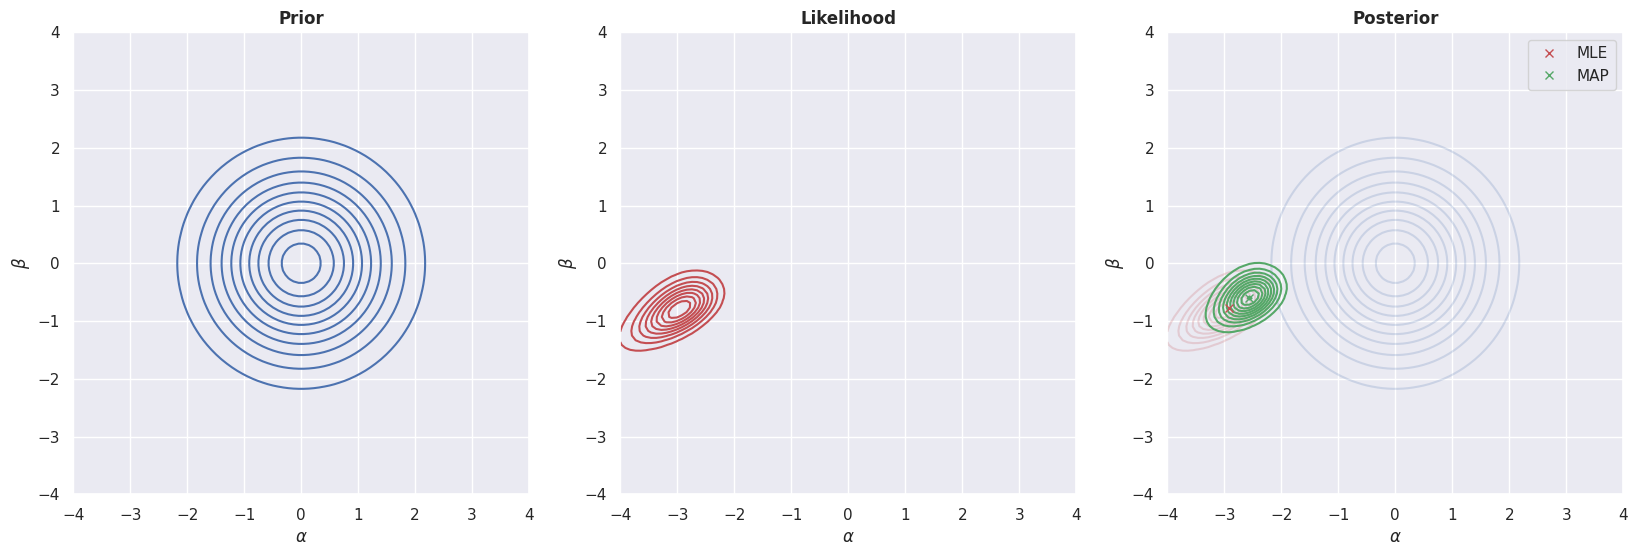

In [5]:
class Grid2D(object):
    """ helper class for evaluating the function func on the grid defined by (alpha, beta)"""

    def __init__(self, alphas, betas, func, name="Grid2D"):
        self.alphas = alphas
        self.betas = betas
        self.grid_size = (len(self.alphas), len(self.betas))
        self.alpha_grid, self.beta_grid = np.meshgrid(alphas, betas, indexing='ij')
        self.func = func
        self.name = name
        
        # evaluate function on each grid point
        self.values = self.func(self.alpha_grid[:, :, None], self.beta_grid[:, :, None]).squeeze()

    def plot_contours(self, ax, color='b', num_contours=10, f=lambda x: x, alpha=1.0, title=None):
        ax.contour(self.alphas, self.betas, f(self.values).T, num_contours, colors=color, alpha=alpha)
        ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
        ax.set_title(self.name, fontweight='bold')

    @property
    def argmax(self):
        idx = np.argmax(self.values)
        alpha_idx, beta_idx = np.unravel_index(idx, self.grid_size)
        return self.alphas[alpha_idx], self.betas[beta_idx]


# define grid points (the only reason for using different numbers of points for alpha and beta is to make debugging easier)
num_alpha, num_beta = 90, 100
alphas = np.linspace(-4, 4, num_alpha)
betas = np.linspace(-4, 4, num_beta)

for sigma2_alpha, sigma2_beta in [(1., 1.), (0.1, 0.1), (10., 10.), (100., 100.), (1., 10.)]:
    print(f"sigma2_alpha = {sigma2_alpha}, sigma2_beta = {sigma2_beta}")

    for _x, _y, _N in [(x, y, N), (x[:10], y[:10], N[:10])]:
        print(f"Number of data points: {len(_x)}")

        # evalute log prior, log likelihood and log joint on the (alpha, beta)-grid
        model = LogisticRegression(_x, _y, _N, sigma2_alpha, sigma2_beta)
        log_prior_grid = Grid2D(alphas, betas, model.log_prior, 'Prior')
        log_lik_grid = Grid2D(alphas, betas, model.log_likelihood, 'Likelihood')
        log_joint_grid = Grid2D(alphas, betas, model.log_joint, 'Posterior')

        # visualize
        fig, ax = plt.subplots(1, 3, figsize=(20, 6))
        log_prior_grid.plot_contours(ax[2], f=np.exp, color='b', alpha=0.2)
        log_lik_grid.plot_contours(ax[2], f=np.exp, color='r', alpha=0.2)

        for idx_plot, grid in enumerate([log_prior_grid, log_lik_grid, log_joint_grid]):
            grid.plot_contours(ax[idx_plot], f=np.exp, color=colors[idx_plot])

        # compute and plot MLE and MAP estimators
        alpha_MLE, beta_MLE = log_lik_grid.argmax
        alpha_MAP, beta_MAP = log_joint_grid.argmax

        ax[2].plot(alpha_MLE, beta_MLE, 'rx', label='MLE')
        ax[2].plot(alpha_MAP, beta_MAP, 'gx', label='MAP')
        ax[2].legend()

        plt.show()
        break
    break


**Task 2.2**: When plotting the contours of the posterior distribution, we actually evaluate the joint distribution and not the posterior distribution . Why is this okay when making contour plots?




**Task 2.3**: Use the code above to experiment and investigate the relationship between the prior, likelihood and posterior. What happens if you change the prior variances of $\alpha, \beta$? E.g. $\sigma^2_{\alpha} = \sigma^2_{\beta} = 10$, $\sigma^2_{\alpha} = \sigma^2_{\beta} = 100$, $\sigma^2_{\alpha} = \sigma^2_{\beta} = 0.1$? What happens if $\sigma^2_\alpha = 1$ and $\sigma^2_{\beta} = 10$?

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*

**Task 2.4**: What happens to the MLE and MAP estimators when you change the variances of the prior?

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*

**Task 2.5**: What happens to the prior, likelihood and posterior if you only use a subset of the data? Use the code above to experiment and investigate what happens, e.g. use the first 10 data instead of the full $M = 23$ datapoints.

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*





# Part 3:  Making predictions using point estimates

Our model for the probability of failure for each individual o-ring is given by

$$\begin{align*}
\theta(x) = \sigma(\alpha + \beta x),
\end{align*}
$$

where $\alpha, \beta \in \mathbb{R}$ are unknown parameters. Since we do not know the values of the parameters, we can **estimate** them from the data in several ways. The simplest way is via the maximum likelihood estimator (MLE). That is, picking the parameter values that maximizes the likelihood of the data:

$$\begin{align*}
\hat{\alpha}_{\text{MLE}}, \hat{\beta}_{\text{MLE}} = \arg\max_{\alpha, \beta \in \mathbb{R}} p(\mathbf{y}|\mathbf{x}, \alpha, \beta).
\end{align*}
$$

In practice, we most often due this using gradient-based optimization. However, in this exercise, we will simply pick the parameters values that maximizes the likelihood function on the grid, which works well for 2D problems. Instead of using the MLE, we can also use the Maximum a posteriori (MAP) estimator. That is, picking the point that maximizes the posterior distribution:

$$\begin{align*}
\hat{\alpha}_{\text{MAP}}, \hat{\beta}_{\text{MAP}} = \arg\max_{\alpha, \beta} p(\alpha, \beta|\mathbf{y},\mathbf{x}).
\end{align*}
$$

After obtaining an estimate of the parameters, we can use a **plugin approximation** for $\theta(x)$ by simply inserting the estimated values for $\alpha$ and $\beta$:
$$\begin{align*}
\hat{\theta}(x) = \sigma(\hat{\alpha} + \hat{\beta} x),
\end{align*}
$$

and then use $\hat{\theta}$ for making predictions.


**Task 3.1**: Compute and plot the predicted probability $\hat{\theta}(x)$ for $x$ corresponding to temperatures $t \in \left[-10, 40\right]$ for both MLE and MAP estimators.


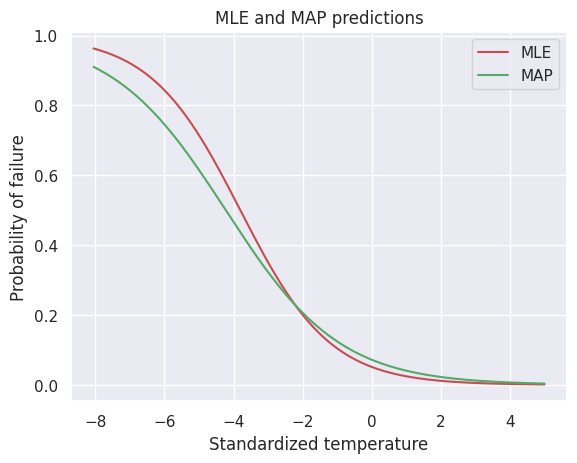

In [6]:
# data for predictions
temp_pred = np.linspace(-10, 40, 500)
x_pred = standardize(temp_pred)
N_pred = 6

model = LogisticRegression(x, y, N)
theta_MLE = Grid2D(alphas, betas, model.log_likelihood, 'Likelihood').argmax
theta_MAP = Grid2D(alphas, betas, model.log_joint, 'Posterior').argmax

plt.plot(x_pred, model.theta(x_pred, *theta_MLE), 'r-', label='MLE')
plt.plot(x_pred, model.theta(x_pred, *theta_MAP), 'g-', label='MAP')

plt.legend()
plt.xlabel('Standardized temperature')
plt.ylabel('Probability of failure')
plt.title('MLE and MAP predictions')

plt.show()


# Part 4:  Approximating the posterior using a grid approximation

Rather than using point estimates, we will now turn to full Bayesian inference to be able to properly reason above the uncertainty of our predictions. In contrast to the Beta-binomial model, the logistic regression model is **not a conjugate model**, which means we cannot compute the posterior distribution $p(\alpha, \beta|\mathbf{y}, \mathbf{x})$ analytically. Instead, we will use a very simple **grid approximation** $q(\alpha, \beta)$ to represent the posterior distribution:

$$\begin{align*}
p(\alpha, \beta|\mathbf{y}, \mathbf{x}) \approx q(\alpha, \beta).
\end{align*}
$$

To construct the grid approximation $q(\alpha, \beta)$, we need three steps:

1) **Define grid**: First we need to the define grid for $(\alpha, \beta)$. Typically, we choose an appropriate discrete set of values for $\alpha$ and $\beta$ individually, i.e. $\left\lbrace \alpha_i \right\rbrace_{i=1}^I$ and $\left\lbrace \beta_i \right\rbrace_{j=1}^J$, and then take the $(\alpha, \beta)$-grid to be the Cartesian product.

2) **Evaluation:** Next, we need to evaluate the function $p(\alpha, \beta| \mathbf{y, x})$ on each point in the $(\alpha, \beta)$-grid. Importantly, here we only need to evaluate the posterior **up to a normalization constant**, and hence, **we can evaluate the joint distribution instead of the posterior**. Moreover, for numerical reasons, we often evaluate the **logarithm of the joint distribution**.

3) **Normalization**: To ensure that our approximation is a valid distribution, we need to make it sum to $1$. To achieve this, we compute the sum of $p(\mathbf{y}, \alpha, \beta| \mathbf{x})$ across all grid points to approximate the normalization constant $Z$.

That is, 
$$\begin{align*}
q(\alpha_i, \beta_j) = \frac{1}{Z}p(\bm{y}, \alpha_i, \beta_j| \mathbf{x}) = \frac{1}{Z}\tilde{\pi}_{ij} = \pi_{ij}, 
\end{align*}
$$
where we have defined $\log \tilde{\pi}_{ij} = \log p(\bm{y}, \alpha_i, \beta_j| \mathbf{x})$ and $\pi_{ij} = \frac{1}{Z}\tilde{\pi}_{ij}$ for each point on the grid $(\alpha_i, \beta_j)$. The normalization constant then becomes
$$\begin{align*}
Z = \sum_{i,j} p(\mathbf{y}, \alpha_i, \beta_j| \mathbf{ x}) = \sum_{i,j}\tilde{\pi}_{ij} = \sum_{i=1}^I \sum_{j=1}^J \tilde{\pi}_{ij},
\end{align*}
$$
where the sum is over all the points in the grid. Note that $q(\alpha, \beta) = 0$ when evaluated on any point not belonging to the pre-defined $(\alpha, \beta)$-grid.

As we will see later, the grid approximation makes it easy for us to 1) compute expectations with respect to the posterior and 2) generate samples from the posterior, which will allow us to make inferences about the parameters $\alpha$ and $\beta$ as well as make predictions will taking the uncertainty into account.

The purpose of the class $\texttt{GridApproximation2D}$ given below is to approximate the posterior distribution of the logistic regression model using a grid approximation. We will re-use the code from the $\texttt{Grid2D}$-class to implemented step 1) and step 2) above. Hence, we basically also need to carry out the step 3.

**Task 4.1**: Complete the implementation of the $\texttt{prep approximation}$-function below. Your task is to make sure that the $\texttt{probability grid}$-variable contains all the $\pi_{ij}$ defined above with the proper normalization.

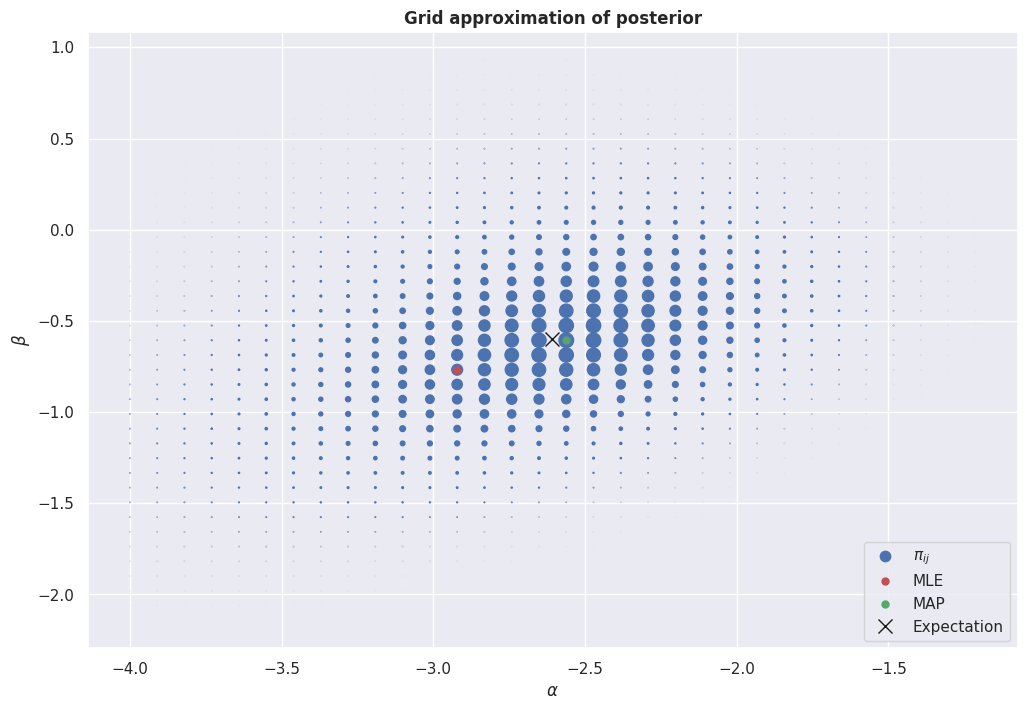

In [7]:
class GridApproximation2D(Grid2D):

    def __init__(self, alphas, betas, log_joint, threshold=1e-8, name="GridApproximation2D"):
        Grid2D.__init__(self, alphas, betas, log_joint, name)
        self.threshold = threshold
        self.prep_approximation()
        self.compute_marginals()
        self.sanity_check()
        
    def prep_approximation(self):
        
        # [num_alpha, num_beta]-sized matrix of the log joint evaluated on the grid 
        self.log_joint_grid = self.values
        self.log_joint_grid = self.log_joint_grid - np.max(self.log_joint_grid)

        # [num_alpha, num_beta]-matrix of \pi_{ij}-values summing to 1.
        self.probabilities_grid = np.exp(self.log_joint_grid)
        self.probabilities_grid = self.probabilities_grid / np.sum(self.probabilities_grid)

        # flatten for later convinience
        self.alphas_flat = self.alpha_grid.flatten()                                             # shape: [num_alpha*num_beta] = [num_outcomes]
        self.betas_flat = self.beta_grid.flatten()                                               # shape: [num_alpha*num_beta] = [num_outcomes]
        self.num_outcomes = len(self.alphas_flat)                                                # shape: scalar 
        self.probabilities_flat = self.probabilities_grid.flatten()                              # [num_outcomes]

    def compute_marginals(self):
        _sum = self.probabilities_grid.sum()
        self.pi_alpha = self.probabilities_grid.sum(axis=1) / _sum
        self.pi_beta = self.probabilities_grid.sum(axis=0) / _sum

        # compute marginal distribution using sum rule
    def compute_expectation(self, f):
        """ computes expectation of f(alpha, beta) wrt. the grid approximation """
        return np.sum(f(self.alphas_flat, self.betas_flat)*self.probabilities_flat, axis=0)
    
    def sample(self, num_samples=1):
        """ generate num_samples from the grid approximation distribution """
        idx = np.random.choice(np.arange(self.num_outcomes), p=self.probabilities_flat, size=num_samples)
        return self.alphas_flat[idx], self.betas_flat[idx]

    def visualize(self, ax, scaling=8000, title='Grid approximation'):
        idx = self.probabilities_flat > self.threshold
        ax.scatter(self.alphas_flat[idx], self.betas_flat[idx], scaling*self.probabilities_flat[idx],label='$\pi_{ij}$')        
        ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
        ax.set_title(title, fontweight='bold')

    def sanity_check(self):
        assert self.probabilities_grid.shape == self.grid_size, "Probability grid does not have shape [num_alphas, num_betas] (self.grid_size). Check your implementation."
        assert np.all(self.probabilities_grid >= 0), "Not all values in probability grid are non-negative. Check your implementation."
        assert np.allclose(self.probabilities_grid.sum(), 1), "Values in probability grid do not sum to one. Check your implementation."

# grid
num_alpha, num_beta = 90, 100
alphas = np.linspace(-4, 4, num_alpha)
betas = np.linspace(-4, 4, num_beta)

# model
model = LogisticRegression(x, y, N, sigma2_alpha=1.0, sigma2_beta=1.0)

# construct grid approximation for posterior
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')

# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
post_approx.visualize(ax, title='Grid approximation of posterior')
ax.plot(alpha_MLE, beta_MLE, 'r.', label='MLE', markersize=10)
ax.plot(alpha_MAP, beta_MAP, 'g.', label='MAP', markersize=10)
ax.plot((alphas * post_approx.pi_alpha).sum(), (betas * post_approx.pi_beta).sum(), 'kx', label='Expectation', markersize=10)
ax.legend()

plt.show()


If the previous task was implemented correctly, the code about should produce a visualization of the grid approximation. The blue dots show the position of all the grid points, and the radius of the blue dots is controlled by the size of the corresponding weight $\pi_{ij}$. For easier interpretation, we do not plot points where $\pi_{ij}$ is smaller than $10^{-8}$. 


Our first order of business after having obtained the posterior distribution is to produce estimates of the parameters $\alpha$ and $\beta$ as well to quantify the uncertainty, i.e. we will estimate the posterior mean, posterior standard deviation and 95% credibility interval for both $\alpha$ and $\beta$. For this purpose, it is more convenient to work with the marginal posterior distributions of $\alpha$ and $\beta$, which can be readily obtained from the joint posterior approximation $q(\alpha, \beta)$ using the **sum rule**:

$$\begin{align*}
q(\alpha_i) &= \sum_{j} q(\alpha_i, \beta_j) = \sum_{j} \pi_{ij} = \pi^{\alpha}_i\\
q(\beta_j) &= \sum_{i} q(\alpha_i, \beta_j) = \sum_{i} \pi_{ij} = \pi^{\beta}_j,
\end{align*}$$

i.e. $\pi^{\alpha} = q(\alpha_i)$ is the (approximate) marginal posterior probability of $p(\alpha = \alpha_i|y)$.

**Task 4.2**: Go back up the class $\texttt{GridApproximation2D}$ and implemented the $\texttt{compute marginals}$-function. Use it to compute and plot the probability mass functions for the approximate posterior marginal distributions $q(\alpha)$ and $q(\beta)$ as a function of $\alpha$ and $\beta$, respectively.




**Task 4.3**: Compute the posterior mean, standard deviation and 95% credibility interval for $\alpha$ and $\beta$ using the grid approximation by completing the implementation of $\texttt{DiscreteDistribution1D}$-class below. Use the figures from the previous task to verify that your results are (approximately) correct.

*Hints*:
- The mean of a discrete random variable X with PMF $P(X = x)$ is given by $\mathbb{E}\left[X\right] = \sum_{i} x_i P(X = x_i)$, where the sum is over all the possible outcomes of $X$.
- The variance of a discrete random variable X with PMF $P(X = x)$ is given by $\mathbb{V}\left[X\right] = \sum_{i} \left(x_i - \mathbb{E}\left[X\right]\right)^2 P(X = x_i)$, where the sum is over all the possible outcomes of $X$.
- A 95%-interval for a random variable $X$ is any interval $\left[\ell, u\right]$ such that $P(\ell \leq X \leq  u) \approx 0.95$. A central 95% percent interval is obtained by splitting the last 5\% of probability mass among the two tails, i.e. choose $\ell$ s.t. $P(\ell \leq X) \approx 0.025$ and $u$ s.t. $P(X\leq u) \approx 0.975$.  You can implement this in several ways, either by brute-force search or by first computing the quantile function. See Section 4.6.6 in Murphy1 for more details.

95% credible interval for alpha: [-3.28089888 -2.02247191]
95% credible interval for beta: [-1.17171717 -0.11919192]


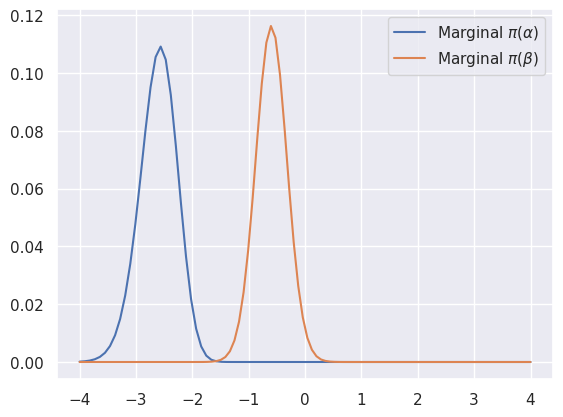

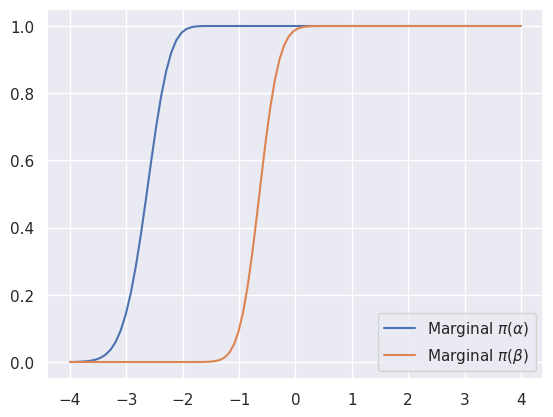

In [8]:
alpha_pdf = post_approx.pi_alpha
beta_pdf = post_approx.pi_beta

alpha_cdf = np.cumsum(alpha_pdf)
beta_cdf = np.cumsum(beta_pdf)

# 95% credible interval
alpha_samples, beta_samples = post_approx.sample(1000)
alpha_int, beta_int = np.percentile(alpha_samples, [2.5, 97.5]), np.percentile(beta_samples, [2.5, 97.5])
print(f"95% credible interval for alpha: {alpha_int}")
print(f"95% credible interval for beta: {beta_int}")

plt.plot(alphas, alpha_pdf, label='Marginal $\\pi(\\alpha)$')
plt.plot(betas, beta_pdf, label='Marginal $\\pi(\\beta)$')
plt.legend()
plt.show()

plt.plot(alphas, alpha_cdf, label='Marginal $\\pi(\\alpha)$')
plt.plot(betas, beta_cdf, label='Marginal $\\pi(\\beta)$')
plt.legend()
plt.show()



In [9]:
from functools import cached_property


class DiscreteDistribution1D(object):

    def __init__(self, outcomes, probabilities, name='DiscreteDistribution'):
        """ represents discrete random variable X in terms of outcomes and probabilities """
        self.outcomes = outcomes
        self.probabilities = probabilities
        assert self.outcomes.shape == self.probabilities.shape
        self.name = name

    def CDF(self, x):
        """ P[X <= x] """
        idx = self.outcomes <= x
        return np.sum(self.probabilities[idx]) 
    
    def quantile(self, p):
        """ Q(p) = inf {x | p < CDF(x)} """
        cdf_values = np.cumsum(self.probabilities) 
        idx = np.where(np.logical_or(p < cdf_values, np.isclose(p, cdf_values)))[0]
        return np.min(self.outcomes[idx])
    
    @cached_property
    def mean(self):
        """ return scalar corresponding to the mean of the discrete distribution """
        return np.sum(self.outcomes * self.probabilities)
    
    @cached_property
    def variance(self):
        """ return scalar corresponding to the variance of the discrete distribution """
        return np.sum((self.outcomes - self.mean)**2 * self.probabilities)
    
    def central_interval(self, interval_size=95):
        """ return tuple (lower, upper) corresponding to the central interval of the discrete distribution """
        c = 1.-interval_size/100.
        return self.quantile(c/2), self.quantile(1-c/2)
    
    def print_summary(self):
        print(f'Summary for {self.name}')
        print(f'\tMean:\t\t\t\t{self.mean:3.2f}')
        print(f'\tStd. dev.:\t\t\t{np.sqrt(self.variance):3.2f}')
        print(f'\t95%-credibility interval:\t[{self.central_interval()[0]:3.2f}, {self.central_interval()[1]:3.2f}]\n')


# example use and sanity sanity checks using classic six-sided die
outcomes, probs = np.arange(1,6+1), np.ones(6)/6
sixsided_die = DiscreteDistribution1D(outcomes, probs)
assert np.allclose(sixsided_die.mean, 3.5), f"The mean of a sixsided die should be 3.5, but the value was {sixsided_die.mean:3.2f}. Check your implementation."
assert np.allclose(sixsided_die.variance, 35/12), f"The variance of a sixsided die should be approximately 2.92, but the value was {sixsided_die.variance:3.2f}. Check your implementation."
assert np.allclose(sixsided_die.central_interval(95), (1, 6)), f"The (approximate) 95% central interval of a sixsided die should be (1,6), but the value was {sixsided_die.central_interval(95)}. Check your implementation."

# summarize posterior marginals for alpha and beta
post_alpha_marginal = DiscreteDistribution1D(post_approx.alphas, post_approx.pi_alpha, "posterior distribution of alpha")
post_beta_marginal = DiscreteDistribution1D(post_approx.betas, post_approx.pi_beta, "posterior distribution of beta")

post_alpha_marginal.print_summary()
post_beta_marginal.print_summary()



Summary for posterior distribution of alpha
	Mean:				-2.61
	Std. dev.:			0.33
	95%-credibility interval:	[-3.28, -2.02]

Summary for posterior distribution of beta
	Mean:				-0.60
	Std. dev.:			0.28
	95%-credibility interval:	[-1.17, -0.04]






**Task 4.4**: Compute the prior and posterior probability that $\beta < 0$. 




# Part 5:  Propagating uncertainty from parameters to predictions

We will now turn our attention to making predictions. For example, we want to predict the following quantities for a given temperature $t^* \in \mathbb{R}$:

- The probability of failure for each o-ring
- The probability of at least one o-ring failing
- The expected number of failing o-rings
- A 95\%-credibility interval for then number of failed o-rings

**Assuming we know** the value of $\alpha$ and $\beta$, all quantities above are easily computed from the predictive likelihood

$$\begin{align}
p(y^*|x^*, \alpha, \beta) = \text{Bin}(y^*|N^*, \alpha, \beta)
\end{align}
$$

The simplest approach for making predictions is to use a **plugin approximation**. That is, we simply plug in one of our point estimators for $\alpha$ and $\beta$ into the equation above, e.g. the MLE or MAP estimator. This is usually fast and easy to do, but the significant drawback is that it tends to produce **overconfident** predictions because it ignores the uncertainty for $\theta^*$. Instead, we can propagate the uncertainty from the posterior distribution $q(\alpha, \beta)$ to the predictive distribution using **marginalization** via the sum:

$\begin{align}
p(y^*|\mathbf{y}, \mathbf{x}, x^*) = \int \int p(y^*|x^*, \alpha, \beta) p(\alpha, \beta|\mathbf{y}, \mathbf{x}) \text{d}\alpha \text{d}\beta = \mathbb{E}_{p(\alpha, \beta|\mathbf{y}, \mathbf{x})}\left[p(y^*|x^*, \alpha, \beta)\right] \approx \mathbb{E}_{q(\alpha, \beta)}\left[p(y^*|x^*, \alpha, \beta)\right].
\end{align}$

That is, when we make predictions, we average over the posterior distribution. **Instead of picking a single set of parameters, we consider all possible values for $\alpha$ and $\beta$ and weigh them according to their posterior probability**. This may be abstract, but the grid approximation can help understand this more intuitively:

$\begin{align}
p(y^*|\mathbf{y}, \mathbf{x}, x^*) = \mathbb{E}_{p(\alpha, \beta|\mathbf{y})}\left[p(y^*|x^*, \alpha, \beta)\right]\approx \mathbb{E}_{q(\alpha, \beta)}\left[p(y^*|x^*, \alpha, \beta)\right] = \sum_{ij} p(y^*|x^*, \alpha_i, \beta_j) \pi_{ij},
\end{align}
$

where we literally evaluate $p(y^*|x^*, \alpha, \beta)$ for each possible set of parameters $(\alpha_i, \beta_j)$ and weigh them by the posterior probability $\pi_{ij} = q(\alpha_i, \beta_j)$. We refer to the distribution $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$ as the **posterior predictive distribution**. Recall, we can also cast the plugin approximations as approximation over the posterior predictive distribution, where the posterior is approximated by a posterior distribution that as all the mass on the single point $(\hat{\alpha}_{MLE}, \hat{\beta}_{\text{MLE}})$.


The code below uses the plugin approximation for the MLE/MAP estimator to compute and plot the posterior predictive distribution $p(y^*=k|\mathbf{y}, \mathbf{x}, x^*)$ for $k \in \left\lbrace 0, 1, \dots 6\right\rbrace$. The code also reports the mean and a 95\% interval for each methods for each temperatures (assuming the tasks above have been solved). 

**Task 5.1**: Compute and plot and the full posterior predictive distribution $p(y^*=k|\mathbf{y}, \mathbf{x}, x^*)$ with $k \in \left\lbrace 0, 1, \dots 6\right\rbrace$ for $t = 25^{\circ}C$ and $t = 0^{\circ}C$. 



/tmp/ipykernel_73664/1077224247.py:29: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  pred_lik_bayes_probs = np.sum((_prob * pred_lik(ks, x_star, _alpha, _beta)


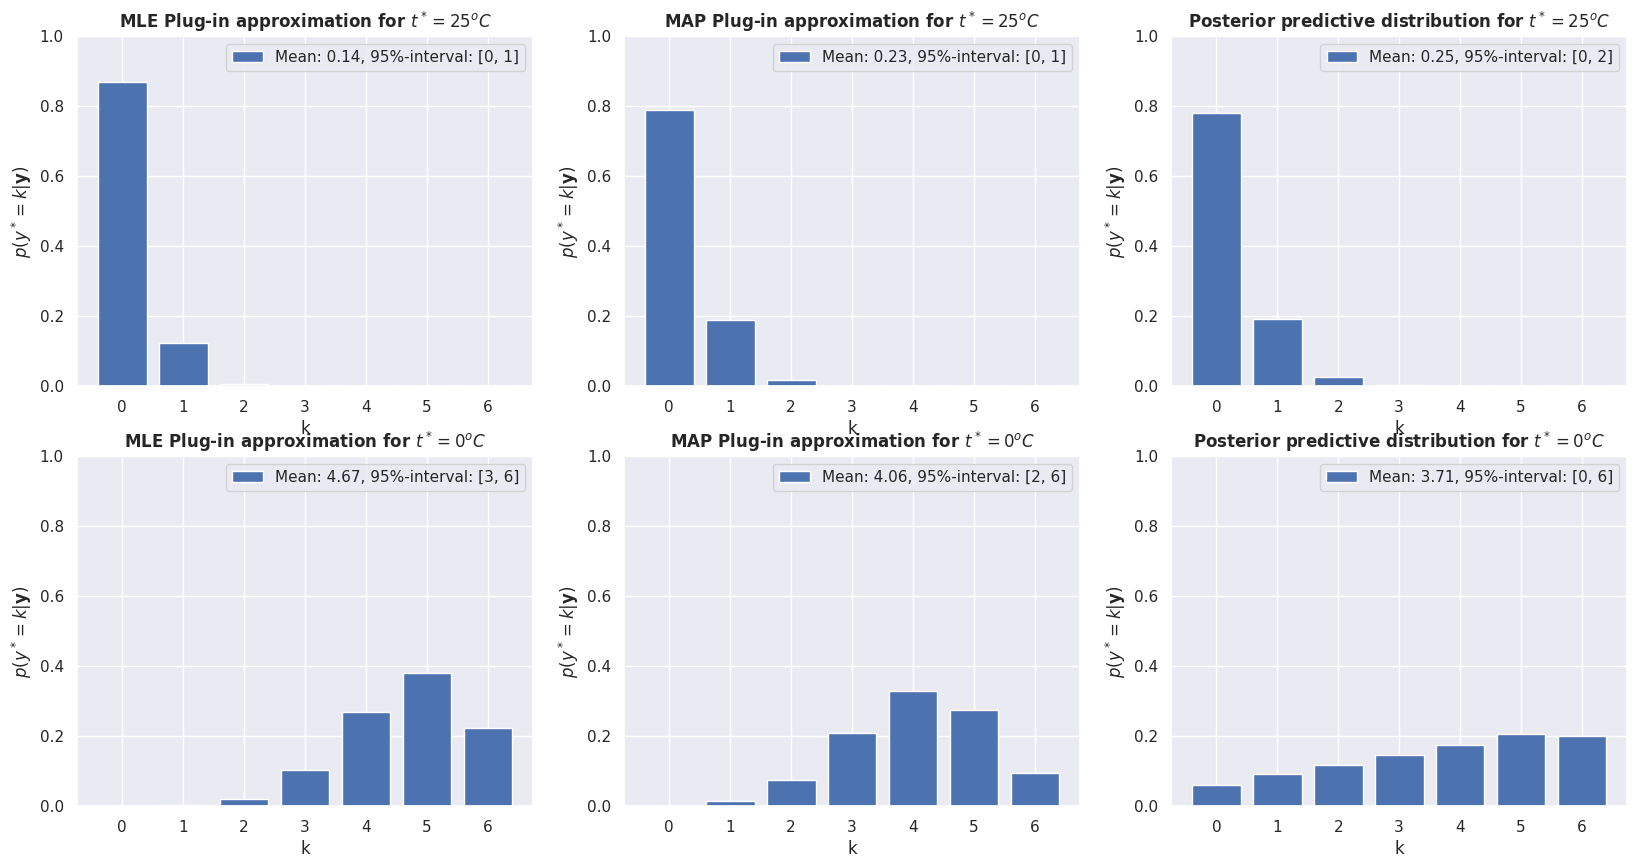

In [12]:
# target temperatures t^*
temp_stars = [25, 0]

# outcome space for y^*
ks = np.arange(0, 6+1)

# predictive likelihood p(y^*=k|x^*, alpha, beta)
pred_lik = lambda k, x_star, alpha, beta: binom_dist.pmf(k=k, n=6, p=model.theta(x_star, alpha, beta))

# prep figure
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

mean_and_interval_label = lambda dist: f'Mean: {dist.mean:3.2f}, 95%-interval: [{dist.central_interval()[0]:d}, {dist.central_interval()[1]:d}]'

for n, t_star in enumerate(temp_stars):

    # standardize to get x^*
    x_star = standardize(t_star)

    # compute plugin approximations using MLE and MAP. Shape must be [7] (matching the shape of ks)
    pred_lik_probs_MLE = pred_lik(ks, x_star, alpha_MLE, beta_MLE)
    pred_lik_probs_MAP = pred_lik(ks, x_star, alpha_MAP, beta_MAP)
    
    pred_lik_bayes_probs = np.sum((_prob * pred_lik(ks, x_star, _alpha, _beta)
                                   for _alpha, _beta, _prob in zip(post_approx.alphas_flat, post_approx.betas_flat, post_approx.probabilities_flat)),
                                  axis=0)

    # prepare for plotting etc
    pred_dist_MLE = DiscreteDistribution1D(ks, pred_lik_probs_MLE, name='MLE Plug-in approximation')
    pred_dist_MAP = DiscreteDistribution1D(ks, pred_lik_probs_MAP, name='MAP Plug-in approximation')
    pred_dist_bayes = DiscreteDistribution1D(ks, pred_lik_bayes_probs, name="Posterior predictive distribution")

    # plot
    for i, dist in enumerate([pred_dist_MLE, pred_dist_MAP, pred_dist_bayes]):
        ax[n, i].bar(ks, dist.probabilities, label=mean_and_interval_label(dist))
        ax[n, i].set(xlabel='k', ylabel='$p(y^* = k|\\mathbf{y})$', ylim =(0, 1))
        ax[n, i].set_ylim((0, 1))
        ax[n, i].set_title(f'{dist.name} for $t^* = {t_star}^oC$', fontweight='bold')
        ax[n, i].set(xlabel='k', ylabel='$p(y^* = k|\\mathbf{y})$', ylim =(0, 1))
        ax[n, i].legend()


**Task 5.2**: Comment on the differences between the results obtained using plugin approximations, i.e. the MLE/MAP estimators, and the posterior predictive distributions. How does the three approximations compare? In regions with data? In regions without data?

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*



In the very last of the exercise, we will visualize the posterior for $f(x)$ and $\theta(x)$ to build over intuition. We will start by drawing a set of random samples of $(\alpha, \beta)$ from the posterior approximation and then compute and visualize $f(x)$ and $\theta(x)$ for each sample. We will repeat this process for the prior distribution $p(\alpha, \beta)$.

**Task 5.3**: The code below generates $\texttt{num samples}$ of $\alpha, \beta$ from both the prior and posterior and plots them. Compute $f(x_{\text{pred}})$ and $\theta(x_{\text{pred}})$ for each of these samples and store them in the variables $\texttt{f samples}$ and $\texttt{theta samples}$ pre-defined below. 

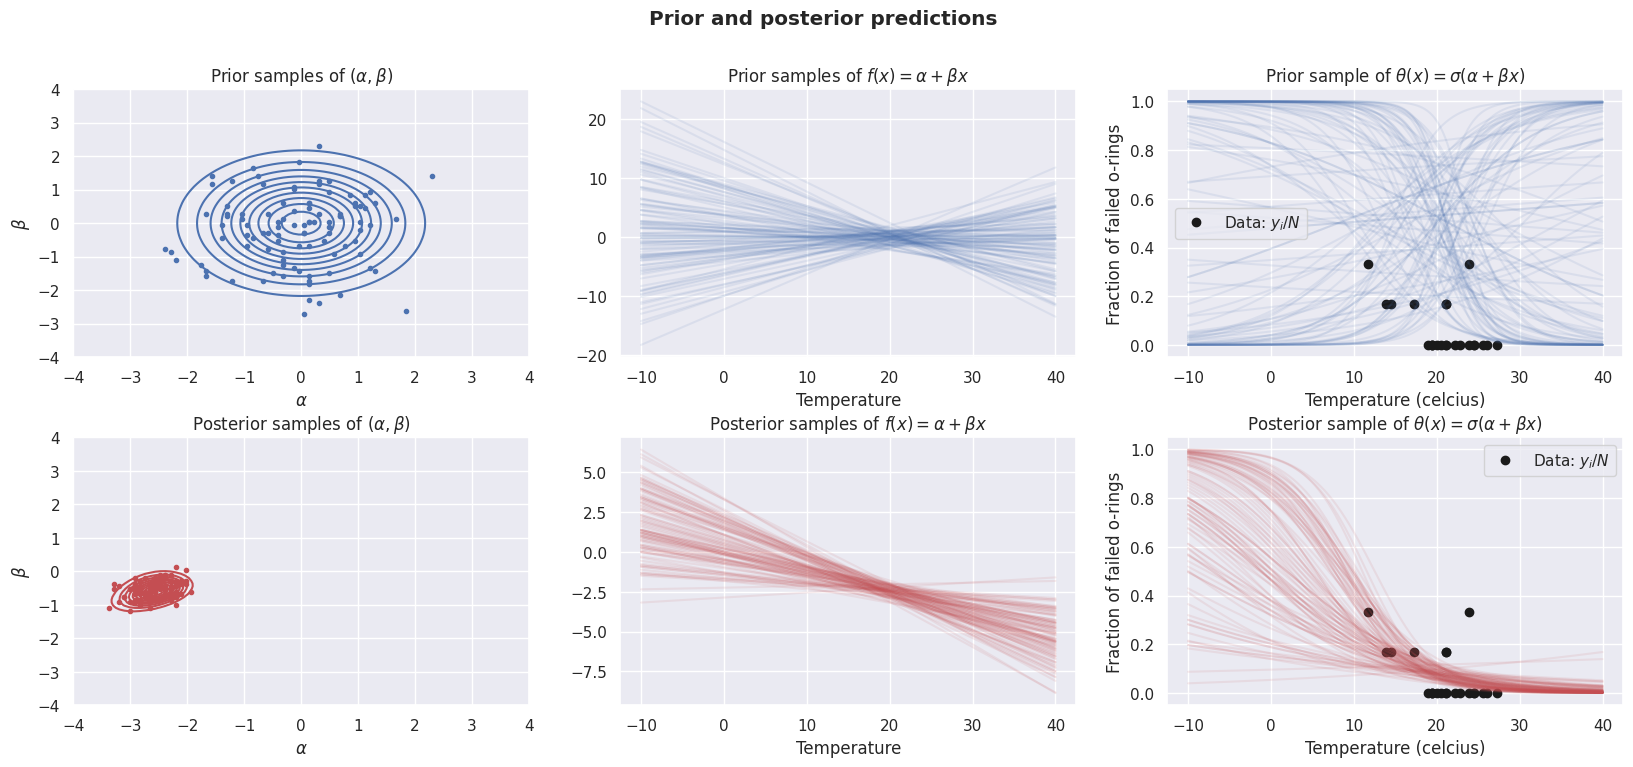

In [14]:
# data for predictions
temp_pred = np.linspace(-10, 40, 500)
x_pred = standardize(temp_pred)
N_pred = 6

# number of samples plot
num_samples = 100

# grid
num_alpha, num_beta = 90, 100
alphas = np.linspace(-4, 4, num_alpha)
betas = np.linspace(-4, 4, num_beta)

# set up prior and posterior for visualization purposes
model = LogisticRegression(x, y, N, sigma2_alpha=1., sigma2_beta=1.)
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')
prior_approx = GridApproximation2D(alphas, betas, model.log_prior, name='Prior')


# plot for each distribution...
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
for idx_plot, dist in enumerate([prior_approx, post_approx]):

    # plot data and contours of distribution
    plot_data(ax[idx_plot, 2], counts=False)
    dist.plot_contours(ax[idx_plot, 0], f=np.exp, color=colors[idx_plot])

    # get (alpha, beta)-samples to visualize
    alpha_samples, beta_samples = dist.sample(num_samples)

    # compute samples of f(x_pred) and theta(x_pred). Shape must be [num_samples, len(temp_pred)] for both f_samples and theta_samples
    f_samples = model.f(x_pred, alpha_samples[:, None], beta_samples[:, None]) 
    theta_samples = model.theta(x_pred, alpha_samples[:, None], beta_samples[:, None]) 

    # plot
    ax[idx_plot, 0].plot(alpha_samples, beta_samples, '.', color=colors[idx_plot])

    # plot each sample of f and theta
    ax[idx_plot, 1].plot(temp_pred, f_samples.T, '', color=colors[idx_plot], alpha=0.1)
    ax[idx_plot, 2].plot(temp_pred, theta_samples.T, '', color=colors[idx_plot], alpha=0.1)
    ax[idx_plot, 2].legend()

    # title and labels
    ax[idx_plot, 0].set(title=f'{dist.name} samples of $(\\alpha, \\beta)$')
    ax[idx_plot, 1].set(title=f'{dist.name} samples of $f(x) = \\alpha + \\beta x$', xlabel='Temperature')
    ax[idx_plot, 2].set(title=f'{dist.name} sample of $\\theta(x) = \sigma(\\alpha + \\beta x)$')

fig.suptitle('Prior and posterior predictions', fontweight='bold')
fig.subplots_adjust(hspace=0.3)


**Task 5.4**: Study the code and plots above and make sure you can explain the following:

- What is plotted in each of the six panels? 
- What is the relationship between each of the dots in the left columns and the curves in the center and right columns?
- How the uncertainty on $f(x)$ and $\theta(x)$ is controlled by the distribution of $(\alpha, \beta)$?
- How well does each of the prior samples match the observed data?
- How well does each of the posterior samples match the observed data?

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*

We can also use posterior samples to the summarize the pointwise posterior mean and 95\% intervals of $f(x)$ and $\theta(x)$ :

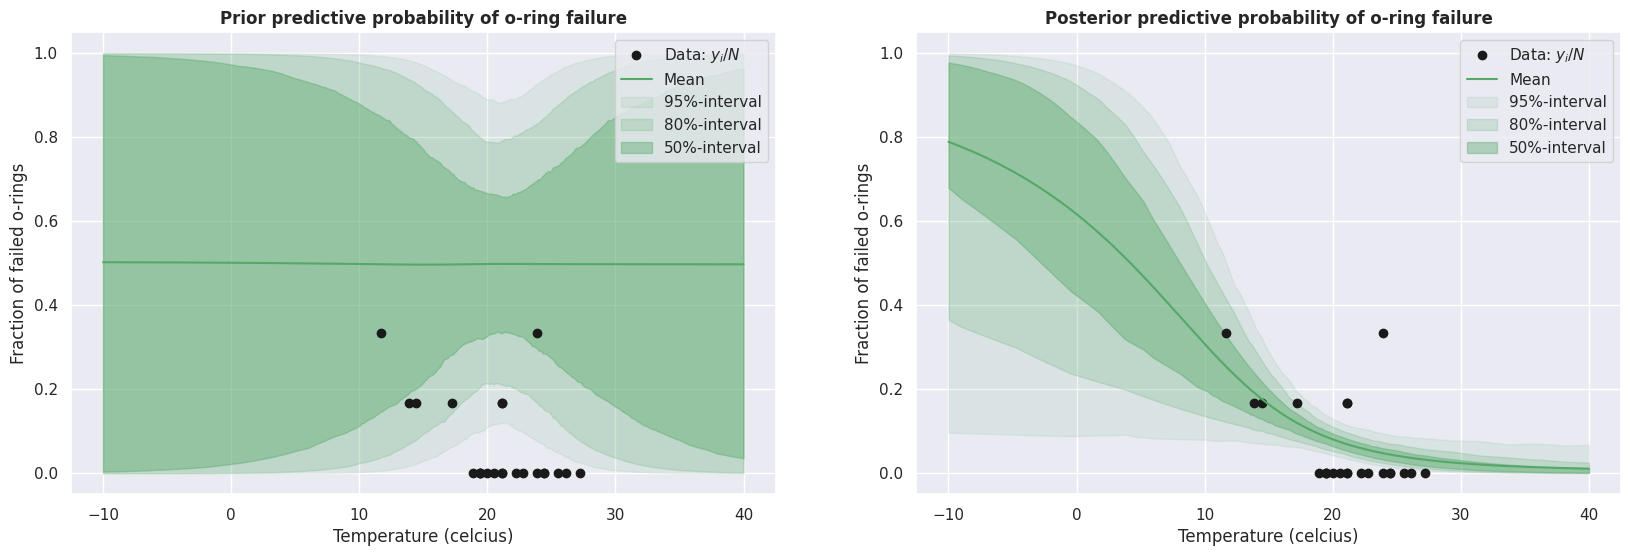

In [15]:
# set up prior and posterior for visualization purposes
model = LogisticRegression(x, y, N, sigma2_alpha=1., sigma2_beta=1.)
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')
prior_approx = GridApproximation2D(alphas, betas, model.log_prior, name='Prior')

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_data(ax[0], counts=False)
plot_data(ax[1], counts=False)

num_samples = 2000

for idx_plot, dist in enumerate([prior_approx, post_approx]):

    alpha_samples, beta_samples = dist.sample(num_samples)

    theta_samples = model.theta(x_pred, alpha_samples[:, None], beta_samples[:, None])
    theta_mean = theta_samples.mean(0)
    theta_lower = np.quantile(theta_samples, 0.025, axis=0)
    theta_upper = np.quantile(theta_samples, 1-0.025,)

    ax[idx_plot].plot(temp_pred, theta_mean, 'g-', label='Mean')
    for interval_size, b in [(0.95, 0.1), (0.8, 0.2), (0.5, 0.4)]:
        c = 1-interval_size
        theta_lower = np.quantile(theta_samples, c/2, axis=0)
        theta_upper = np.quantile(theta_samples, 1-c/2, axis=0)
        ax[idx_plot].fill_between(temp_pred, theta_lower, theta_upper, color='g', alpha=b, label=f'{interval_size*100:2.0f}%-interval')
    ax[idx_plot].legend()
    ax[idx_plot].set_title(f'{dist.name} predictive probability of o-ring failure', fontweight='bold')

**Task 5.5**: Compute and plot the posterior mean and a 95% credibility interval for the probability of obtaining at least one failure among the 6 o-rings

